In [61]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
%matplotlib inline
from pylab import *
from numpy import *
import numpy as np
from PIL import Image
import math
import time
from random import random
from utils import *

(1152, 2048, 3)


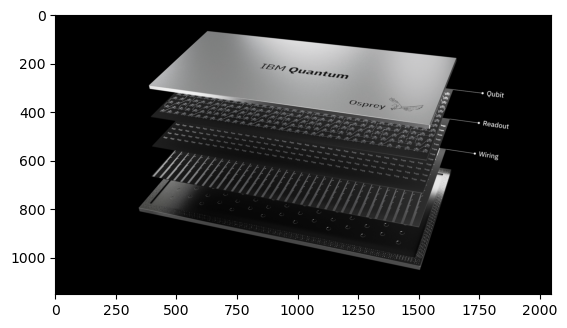

In [33]:
# Image attributes
img_path='52476814366_5b2e98e46d_o.png'  # Be sure to place the image and location of this Jupyter notebook in the same file location

img = Image.open(img_path).convert('RGB')
image = np.array(img)
print(image.shape)
height=image.shape[0]
width=image.shape[1]
imshow(image)

In [34]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from pylab import *
from numpy import *
import numpy as np
import math
from random import random
from scipy.ndimage import geometric_transform
from scipy.ndimage import map_coordinates
from PIL import Image

def drawpoints(image, point, color,output_height, output_width):
    h = point[0]
    w = point[1]
    where_to_draw = []
    where_to_draw.append(point)
    where_to_draw.append([h-1,w])
    where_to_draw.append([h+1,w])
    where_to_draw.append([h,w-1])
    where_to_draw.append([h,w+1])
    new_where_to_draw=[]
    for item in where_to_draw:
        if item[0]>=0 and item[0]<output_height and item[1]>=0 and item[1]<output_width:
            new_where_to_draw.append(item)

    for item in new_where_to_draw:
        if color == 'red':
            image[item[0],item[1]]=[255,102,102]
        elif color == 'green':
            image[item[0],item[1]]=[0,204,0]
        elif color == 'blue':
            image[item[0],item[1]]=[0,128,255]
            
def shift_func(coords,a,b,c,d):
    """ Define the mobius transformation, though backwards """
    # Turn the first two coordinates into an imaginary #
    z = coords[0] + 1j*coords[1]
    w = (d*z-b)/(-c*z+a) #the inverse mobius transform
    # Take the color along for the ride
    return real(w),imag(w),coords[2]

def mobius_fast_interpolation(image, M, mode, output_height=None, output_width=None, user_defined=False, start_points = None, end_points = None):

    
    image = np.array(image)
    original_image=image
    height=image.shape[0]
    width=image.shape[1]
    # Pick output size
    if output_height == None:
        output_height = height
    if output_width == None:
        output_width = width
    if user_defined ==True:
        # Method 1 
        # Pick starting and ending point
        a, b, c, d, original_points,new_points = getabcd_1fix(height,width,start_points, end_points)
    else:
        # Method 2
        # Randomly generated ending point
        a, b, c, d,original_points,new_points  = madmissable_abcd(M,height,width)
    e=[complex(0,0)]*height*width
    z=np.array(e).reshape(height,width)
    for i in range(0,height):
        for j in range(0,width):
            z[i,j]=complex(i,j)
    i=np.array(list(range(0,height))*width).reshape(width,height).T
    j=np.array(list(range(0,width))*height).reshape(height,width)

    r = ones((output_height, output_width,3),dtype=uint8)*255*0        
    w = (a*z+b)/(c*z+d)
    first=real(w)*1
    second=imag(w)*1
    first=first.astype(int)
    second=second.astype(int)
    
    f1=first>=0
    f2=first<output_height
    f= f1 & f2
    s1=second>=0
    s2=second<output_width
    s= s1 & s2
    
    combined = s&f
    


    r[first[combined],second[combined],:]=image[i[combined],j[combined],:]

    r_interpolated = r.copy()
    u=[True]*output_height*output_width
    canvas=np.array(u).reshape(output_height,output_width)
    canvas[first[combined],second[combined]]=False
    converted_empty_index = np.where(canvas == True )
    converted_first = converted_empty_index[0]
    converted_second = converted_empty_index[1]

    new = converted_first.astype(complex)
    new.imag = converted_second


    ori = (d*new-b)/(-c*new+a)

    p=np.hstack([ori.real,ori.real,ori.real])
    k=np.hstack([ori.imag,ori.imag,ori.imag])
    zero=np.zeros_like(ori.real)
    one=np.ones_like(ori.real)
    two=np.ones_like(ori.real)*2
    third = np.hstack([zero,one,two])
    number_of_interpolated_point = len(one)
    e = number_of_interpolated_point
    interpolated_value_unfinished = map_coordinates(image, [p, k,third], order=1,mode=mode ,cval=0)
    t = interpolated_value_unfinished

    interpolated_value = np.stack([t[0:e],t[e:2*e],t[2*e:]]).T

    r_interpolated[converted_first,converted_second,:] = interpolated_value


    new_image=Image.fromarray(r_interpolated)
    uninterpolated_image=Image.fromarray(r)

    # print((r_interpolated==r).sum()/64/64/3)

#     drawpoints(r_interpolated, new_points[0], 'red',output_height, output_width)
#     drawpoints(r_interpolated, new_points[1], 'green',output_height, output_width)
#     drawpoints(r_interpolated, new_points[2], 'blue',output_height, output_width)

#     drawpoints(original_image, original_points[0], 'red',output_height, output_width)
#     drawpoints(original_image, original_points[1], 'green',output_height, output_width)
#     drawpoints(original_image, original_points[2], 'blue',output_height, output_width)

#     drawpoints(r, new_points[0], 'red',output_height, output_width)
#     drawpoints(r, new_points[1], 'green',output_height, output_width)
#     drawpoints(r, new_points[2], 'blue',output_height, output_width)

    figure(figsize=(15, 10))
    subplot(1,3,1)
    title('Original')
    imshow(original_image)
    subplot(1,3,2)
    title('No interpolation')
    imshow(r)
    subplot(1,3,3)
    # figure()
    title('With interpolation')
    imshow(r_interpolated)
    
    return new_image, uninterpolated_image



def getabcd_1fix(height, width, start_points, end_points):
        

    # Fixed start and end points
    
    start1_x, start1_y, start2_x, start2_y, start3_x, start3_y = start_points
    end1_x, end1_y, end2_x, end2_y, end3_x, end3_y = end_points
    zp=[complex(start1_x,start1_y), complex(start2_x, start2_y), complex(start3_x, start3_y)]
    wa=[complex(end1_x, end1_y), complex(end2_x, end2_y),complex(end3_x, end3_y)]

    # This is for ploting points on the output, not useful for calculation
    original_points = np.array([[start1_x,start1_y], [start2_x, start2_y], [start3_x, start3_y]],dtype=int)
    new_points  = np.array([[end1_x, end1_y], [end2_x, end2_y],[end3_x, end3_y]],dtype=int)



    a = np.linalg.det([[zp[0]*wa[0], wa[0], 1], 
                    [zp[1]*wa[1], wa[1], 1], 
                    [zp[2]*wa[2], wa[2], 1]]);
    b = np.linalg.det([[zp[0]*wa[0], zp[0], wa[0]], 
                    [zp[1]*wa[1], zp[1], wa[1]], 
                    [zp[2]*wa[2], zp[2], wa[2]]]);  

    c = np.linalg.det([[zp[0], wa[0], 1], 
                    [zp[1], wa[1], 1], 
                    [zp[2], wa[2], 1]]);

    d = np.linalg.det([[zp[0]*wa[0], zp[0], 1], 
                    [zp[1]*wa[1], zp[1], 1], 
                    [zp[2]*wa[2], zp[2], 1]]);

    return a,b,c,d,original_points,new_points 


# Test if a, b, c, and d fit our criteria
def M_admissable(M, a,b,c,d):
    
    size = 32
    v1 = np.absolute(a) ** 2 / np.absolute(a*d - b*c)
    if not (v1 < M and v1 > 1/M):
        return False

    v2 = np.absolute(a-size*c) ** 2 / (np.absolute(a*d -b*c))
    if not (v2 < M and v2 > 1/M):
        return False

    v3 = np.absolute(complex(a,-size*c)) ** 2 / np.absolute(a*d-b*c)
    if not (v3 < M and v3 > 1/M):
        return False

    v4 = np.absolute(complex(a-size*c,-size*c)) ** 2 / np.absolute(a*d-b*c)
    if not (v4 < M and v4 > 1/M):
        return False
    
    v5 = np.absolute(complex(a-size/2*c,-size/2*c)) ** 2 / (np.absolute(a*d-b*c))
    if not (v5 < M and v5 > 1/M):
        return False

    v6 = np.absolute(complex(size/2*d-b,size/2*d)/complex(a-size/2*c,-size/2*c)-complex(size/2,size/2))
    if not( v6 < size/4):
        return False
    
    
    return  True



def madmissable_abcd(M,height,width):
    test=False 
    while test==False:
        # Zp are the start points (3 points)
        # Wa are the end points  (3 points)
        zp=[complex(height*random(),width*random()), complex(height*random(),width*random()),complex(height*random(),width*random())] 
        wa=[complex(height*random(),width*random()), complex(height*random(),width*random()),complex(height*random(),width*random())]

        # For ploting points on the output, not useful for calculation
        original_points = np.array([[real(zp[0]),imag(zp[0])],
                                  [real(zp[1]),imag(zp[1])],
                                  [real(zp[2]),imag(zp[2])]],dtype=int)
        new_points = np.array([[real(wa[0]),imag(wa[0])],
                                  [real(wa[1]),imag(wa[1])],
                                  [real(wa[2]),imag(wa[2])]],dtype=int)
        
        # transformation parameters
        a = linalg.det([[zp[0]*wa[0], wa[0], 1], 
                      [zp[1]*wa[1], wa[1], 1], 
                      [zp[2]*wa[2], wa[2], 1]]);

        b = linalg.det([[zp[0]*wa[0], zp[0], wa[0]], 
                      [zp[1]*wa[1], zp[1], wa[1]], 
                      [zp[2]*wa[2], zp[2], wa[2]]]);         


        c = linalg.det([[zp[0], wa[0], 1], 
                      [zp[1], wa[1], 1], 
                      [zp[2], wa[2], 1]]);

        d = linalg.det([[zp[0]*wa[0], zp[0], 1], 
                      [zp[1]*wa[1], zp[1], 1], 
                      [zp[2]*wa[2], zp[2], 1]]);
        test=M_admissable(M,a,b,c,d)
#     print('passed')  
    return a,b,c,d,original_points ,new_points

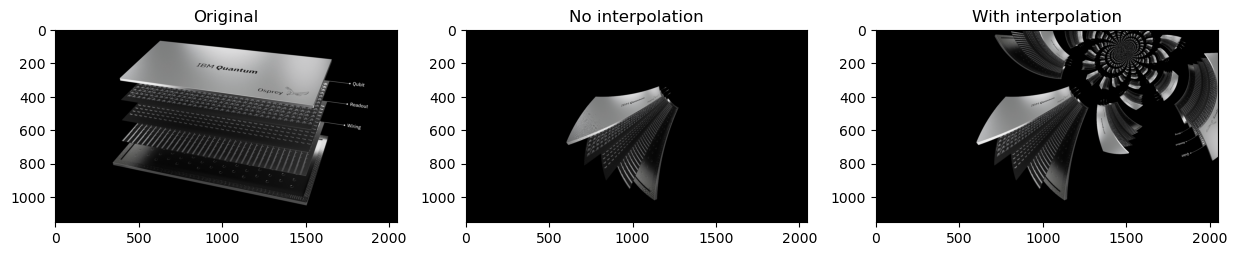

In [47]:
# M must be >1
# The smaller M is itself, the more "normal" the output looks
M=7

# Mode can be chosen from 'reflect’, ‘constant’, ‘nearest’, ‘mirror’, ‘wrap’
mode = 'wrap'

# If user_defined == False, then it is random (recommended)
user_defined = False
start_points = 32, 16, 16, 32, 32, 48 
end_points = 16, 32, 32, 48, 48, 32
new_image, uninterpolated_image = mobius_fast_interpolation(image,
                                                            M, 
                                                            mode = mode,
                                                            output_height=height, 
                                                            output_width=width,
                                                            user_defined=user_defined,
                                                            start_points = start_points,
                                                            end_points = end_points)

In [ ]:
new_image

In [ ]:
uninterpolated_image 

C:\ProgramData\Anaconda3\lib\site-packages\PIL\Image.py:3035: DecompressionBombWarning: Image size (96719052 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


(8517, 11356, 3)


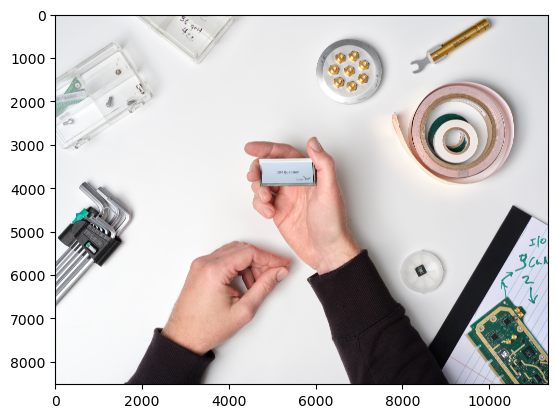

In [28]:
# Image attributes
img_path='52477267393_3472cdf89d_o.jpg'

img = Image.open(img_path).convert('RGB')
image = np.array(img)
print(image.shape)
height=image.shape[0]
width=image.shape[1]
imshow(image)

In [29]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from pylab import *
from numpy import *
import numpy as np
import math
from random import random
from scipy.ndimage import geometric_transform
from scipy.ndimage import map_coordinates
from PIL import Image
def drawpoints(image, point, color,output_height, output_width):
    h = point[0]
    w = point[1]
    where_to_draw = []
    where_to_draw.append(point)
    where_to_draw.append([h-1,w])
    where_to_draw.append([h+1,w])
    where_to_draw.append([h,w-1])
    where_to_draw.append([h,w+1])
    new_where_to_draw=[]
    for item in where_to_draw:
        if item[0]>=0 and item[0]<output_height and item[1]>=0 and item[1]<output_width:
            new_where_to_draw.append(item)

    for item in new_where_to_draw:
        if color == 'red':
            image[item[0],item[1]]=[255,102,102]
        elif color == 'green':
            image[item[0],item[1]]=[0,204,0]
        elif color == 'blue':
            image[item[0],item[1]]=[0,128,255]
            
def shift_func(coords,a,b,c,d):
    """ Define the mobius transformation, though backwards """
    # Turn 1st two coordinates into an imaginary number
    z = coords[0] + 1j*coords[1]
    w = (d*z-b)/(-c*z+a) #the inverse mobius transform
    # Color stuff
    return real(w),imag(w),coords[2]

def mobius_fast_interpolation(image, M, mode, output_height=None, output_width=None, user_defined=False, start_points = None, end_points = None):

    
    image = np.array(image)
    original_image=image
    height=image.shape[0]
    width=image.shape[1]
    # Pick output size
    if output_height == None:
        output_height = height
    if output_width == None:
        output_width = width
    if user_defined ==True:
        # Method 1
        # Pick starting and ending points
        a, b, c, d, original_points,new_points = getabcd_1fix(height,width,start_points, end_points)
    else:
        # Method 2
        # Randomly generated ending point
        a, b, c, d,original_points,new_points  = madmissable_abcd(M,height,width)
    e=[complex(0,0)]*height*width
    z=np.array(e).reshape(height,width)
    for i in range(0,height):
        for j in range(0,width):
            z[i,j]=complex(i,j)
    i=np.array(list(range(0,height))*width).reshape(width,height).T
    j=np.array(list(range(0,width))*height).reshape(height,width)

    r = ones((output_height, output_width,3),dtype=uint8)*255*0        
    w = (a*z+b)/(c*z+d)
    first=real(w)*1
    second=imag(w)*1
    first=first.astype(int)
    second=second.astype(int)
    
    f1=first>=0
    f2=first<output_height
    f= f1 & f2
    s1=second>=0
    s2=second<output_width
    s= s1 & s2
    
    combined = s&f
    


    r[first[combined],second[combined],:]=image[i[combined],j[combined],:]

    r_interpolated = r.copy()
    u=[True]*output_height*output_width
    canvas=np.array(u).reshape(output_height,output_width)
    canvas[first[combined],second[combined]]=False
    converted_empty_index = np.where(canvas == True )
    converted_first = converted_empty_index[0]
    converted_second = converted_empty_index[1]

    new = converted_first.astype(complex)
    new.imag = converted_second


    ori = (d*new-b)/(-c*new+a)

    p=np.hstack([ori.real,ori.real,ori.real])
    k=np.hstack([ori.imag,ori.imag,ori.imag])
    zero=np.zeros_like(ori.real)
    one=np.ones_like(ori.real)
    two=np.ones_like(ori.real)*2
    third = np.hstack([zero,one,two])
    number_of_interpolated_point = len(one)
    e = number_of_interpolated_point
    interpolated_value_unfinished = map_coordinates(image, [p, k,third], order=1,mode=mode ,cval=0)
    t = interpolated_value_unfinished

    interpolated_value = np.stack([t[0:e],t[e:2*e],t[2*e:]]).T

    r_interpolated[converted_first,converted_second,:] = interpolated_value


    new_image=Image.fromarray(r_interpolated)
    uninterpolated_image=Image.fromarray(r)

    # print((r_interpolated==r).sum()/64/64/3)

#     drawpoints(r_interpolated, new_points[0], 'red',output_height, output_width)
#     drawpoints(r_interpolated, new_points[1], 'green',output_height, output_width)
#     drawpoints(r_interpolated, new_points[2], 'blue',output_height, output_width)

#     drawpoints(original_image, original_points[0], 'red',output_height, output_width)
#     drawpoints(original_image, original_points[1], 'green',output_height, output_width)
#     drawpoints(original_image, original_points[2], 'blue',output_height, output_width)

#     drawpoints(r, new_points[0], 'red',output_height, output_width)
#     drawpoints(r, new_points[1], 'green',output_height, output_width)
#     drawpoints(r, new_points[2], 'blue',output_height, output_width)

    figure(figsize=(15, 10))
    subplot(1,3,1)
    title('Original')
    imshow(original_image)
    subplot(1,3,2)
    title('No interpolation')
    imshow(r)
    subplot(1,3,3)
    # figure()
    title('With interpolation')
    imshow(r_interpolated)
    
    return new_image, uninterpolated_image



def getabcd_1fix(height, width, start_points, end_points):
        

    # Fixed start and end points
    
    start1_x, start1_y, start2_x, start2_y, start3_x, start3_y = start_points
    end1_x, end1_y, end2_x, end2_y, end3_x, end3_y = end_points
    zp=[complex(start1_x,start1_y), complex(start2_x, start2_y), complex(start3_x, start3_y)]
    wa=[complex(end1_x, end1_y), complex(end2_x, end2_y),complex(end3_x, end3_y)]

    # For ploting points on the output, not useful for calculation
    original_points = np.array([[start1_x,start1_y], [start2_x, start2_y], [start3_x, start3_y]],dtype=int)
    new_points  = np.array([[end1_x, end1_y], [end2_x, end2_y],[end3_x, end3_y]],dtype=int)



    a = np.linalg.det([[zp[0]*wa[0], wa[0], 1], 
                    [zp[1]*wa[1], wa[1], 1], 
                    [zp[2]*wa[2], wa[2], 1]]);
    b = np.linalg.det([[zp[0]*wa[0], zp[0], wa[0]], 
                    [zp[1]*wa[1], zp[1], wa[1]], 
                    [zp[2]*wa[2], zp[2], wa[2]]]);  

    c = np.linalg.det([[zp[0], wa[0], 1], 
                    [zp[1], wa[1], 1], 
                    [zp[2], wa[2], 1]]);

    d = np.linalg.det([[zp[0]*wa[0], zp[0], 1], 
                    [zp[1]*wa[1], zp[1], 1], 
                    [zp[2]*wa[2], zp[2], 1]]);

    return a,b,c,d,original_points,new_points 


# Test if a, b, c, and d fit user-defined criteria
def M_admissable(M, a,b,c,d):
    
    size = 32
    v1 = np.absolute(a) ** 2 / np.absolute(a*d - b*c)
    if not (v1 < M and v1 > 1/M):
        return False

    v2 = np.absolute(a-size*c) ** 2 / (np.absolute(a*d -b*c))
    if not (v2 < M and v2 > 1/M):
        return False

    v3 = np.absolute(complex(a,-size*c)) ** 2 / np.absolute(a*d-b*c)
    if not (v3 < M and v3 > 1/M):
        return False

    v4 = np.absolute(complex(a-size*c,-size*c)) ** 2 / np.absolute(a*d-b*c)
    if not (v4 < M and v4 > 1/M):
        return False
    
    v5 = np.absolute(complex(a-size/2*c,-size/2*c)) ** 2 / (np.absolute(a*d-b*c))
    if not (v5 < M and v5 > 1/M):
        return False

    v6 = np.absolute(complex(size/2*d-b,size/2*d)/complex(a-size/2*c,-size/2*c)-complex(size/2,size/2))
    if not( v6 < size/4):
        return False
    
    
    return  True



def madmissable_abcd(M,height,width):
    test=False 
    while test==False:
        # Zp are the start points (3 points)
        # Wa are the end points  (3 points)
        zp=[complex(height*random(),width*random()), complex(height*random(),width*random()),complex(height*random(),width*random())] 
        wa=[complex(height*random(),width*random()), complex(height*random(),width*random()),complex(height*random(),width*random())]

        # This is for ploting points on the output, not useful for calculation
        original_points = np.array([[real(zp[0]),imag(zp[0])],
                                  [real(zp[1]),imag(zp[1])],
                                  [real(zp[2]),imag(zp[2])]],dtype=int)
        new_points = np.array([[real(wa[0]),imag(wa[0])],
                                  [real(wa[1]),imag(wa[1])],
                                  [real(wa[2]),imag(wa[2])]],dtype=int)
        
        # transformation parameters
        a = linalg.det([[zp[0]*wa[0], wa[0], 1], 
                      [zp[1]*wa[1], wa[1], 1], 
                      [zp[2]*wa[2], wa[2], 1]]);

        b = linalg.det([[zp[0]*wa[0], zp[0], wa[0]], 
                      [zp[1]*wa[1], zp[1], wa[1]], 
                      [zp[2]*wa[2], zp[2], wa[2]]]);         


        c = linalg.det([[zp[0], wa[0], 1], 
                      [zp[1], wa[1], 1], 
                      [zp[2], wa[2], 1]]);

        d = linalg.det([[zp[0]*wa[0], zp[0], 1], 
                      [zp[1]*wa[1], zp[1], 1], 
                      [zp[2]*wa[2], zp[2], 1]]);
        test=M_admissable(M,a,b,c,d)
#     print('passed')  
    return a,b,c,d,original_points ,new_points

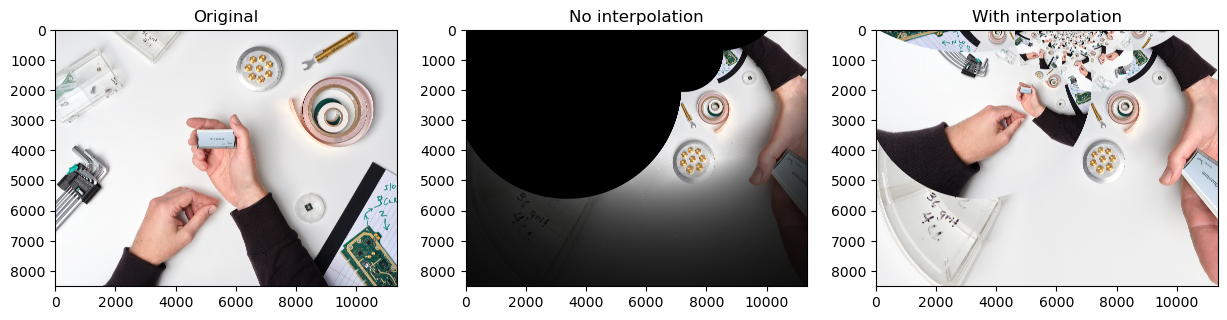

In [30]:
# M must be >1
# The smaller M is, the more "normal" the output looks
M=2

# Mode can be chosen from 'reflect’, ‘constant’, ‘nearest’, ‘mirror’, ‘wrap’
mode = 'wrap'

# If user_defined == False, then it is random (recommended)
user_defined = False
start_points = 32, 16, 16, 32, 32, 48 
end_points = 16, 32, 32, 48, 48, 32
new_image, uninterpolated_image = mobius_fast_interpolation(image,
                                                            M, 
                                                            mode = mode,
                                                            output_height=height, 
                                                            output_width=width,
                                                            user_defined=user_defined,
                                                            start_points = start_points,
                                                            end_points = end_points)

In [ ]:
new_image

In [ ]:
uninterpolated_image 

(1770, 2950, 3)


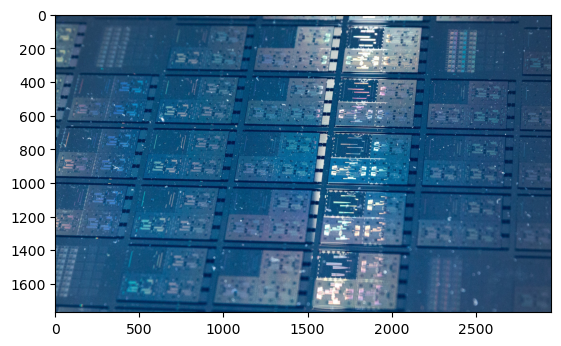

In [52]:
# Image attributes
img_path='16_Qubit_Chip_wafer.jpg'

img = Image.open(img_path).convert('RGB')
image = np.array(img)
print(image.shape)
height=image.shape[0]
width=image.shape[1]
imshow(image)

In [53]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from pylab import *
from numpy import *
import numpy as np
import math
from random import random
from scipy.ndimage import geometric_transform
from scipy.ndimage import map_coordinates
from PIL import Image
def drawpoints(image, point, color,output_height, output_width):
    h = point[0]
    w = point[1]
    where_to_draw = []
    where_to_draw.append(point)
    where_to_draw.append([h-1,w])
    where_to_draw.append([h+1,w])
    where_to_draw.append([h,w-1])
    where_to_draw.append([h,w+1])
    new_where_to_draw=[]
    for item in where_to_draw:
        if item[0]>=0 and item[0]<output_height and item[1]>=0 and item[1]<output_width:
            new_where_to_draw.append(item)

    for item in new_where_to_draw:
        if color == 'red':
            image[item[0],item[1]]=[255,102,102]
        elif color == 'green':
            image[item[0],item[1]]=[0,204,0]
        elif color == 'blue':
            image[item[0],item[1]]=[0,128,255]
            
def shift_func(coords,a,b,c,d):
    """ Define the mobius transformation, although backwards """
    #turn the first two coordinates into an imaginary number
    z = coords[0] + 1j*coords[1]
    w = (d*z-b)/(-c*z+a) #the inverse mobius transform
    #take the color along for the ride
    return real(w),imag(w),coords[2]

def mobius_fast_interpolation(image, M, mode, output_height=None, output_width=None, user_defined=False, start_points = None, end_points = None):

    
    image = np.array(image)
    original_image=image
    height=image.shape[0]
    width=image.shape[1]
    #User can pick output size
    if output_height == None:
        output_height = height
    if output_width == None:
        output_width = width
    if user_defined ==True:
        # Method one 
        # You pick starting and ending point
        a, b, c, d, original_points,new_points = getabcd_1fix(height,width,start_points, end_points)
    else:
        # Method two
        # Randomly generated starting the ending point
        a, b, c, d,original_points,new_points  = madmissable_abcd(M,height,width)
    e=[complex(0,0)]*height*width
    z=np.array(e).reshape(height,width)
    for i in range(0,height):
        for j in range(0,width):
            z[i,j]=complex(i,j)
    i=np.array(list(range(0,height))*width).reshape(width,height).T
    j=np.array(list(range(0,width))*height).reshape(height,width)

    r = ones((output_height, output_width,3),dtype=uint8)*255*0        
    w = (a*z+b)/(c*z+d)
    first=real(w)*1
    second=imag(w)*1
    first=first.astype(int)
    second=second.astype(int)
    
    f1=first>=0
    f2=first<output_height
    f= f1 & f2
    s1=second>=0
    s2=second<output_width
    s= s1 & s2
    
    combined = s&f
    


    r[first[combined],second[combined],:]=image[i[combined],j[combined],:]

    r_interpolated = r.copy()
    u=[True]*output_height*output_width
    canvas=np.array(u).reshape(output_height,output_width)
    canvas[first[combined],second[combined]]=False
    converted_empty_index = np.where(canvas == True )
    converted_first = converted_empty_index[0]
    converted_second = converted_empty_index[1]

    new = converted_first.astype(complex)
    new.imag = converted_second


    ori = (d*new-b)/(-c*new+a)

    p=np.hstack([ori.real,ori.real,ori.real])
    k=np.hstack([ori.imag,ori.imag,ori.imag])
    zero=np.zeros_like(ori.real)
    one=np.ones_like(ori.real)
    two=np.ones_like(ori.real)*2
    third = np.hstack([zero,one,two])
    number_of_interpolated_point = len(one)
    e = number_of_interpolated_point
    interpolated_value_unfinished = map_coordinates(image, [p, k,third], order=1,mode=mode ,cval=0)
    t = interpolated_value_unfinished

    interpolated_value = np.stack([t[0:e],t[e:2*e],t[2*e:]]).T

    r_interpolated[converted_first,converted_second,:] = interpolated_value


    new_image=Image.fromarray(r_interpolated)
    uninterpolated_image=Image.fromarray(r)

    # print((r_interpolated==r).sum()/64/64/3)

#     drawpoints(r_interpolated, new_points[0], 'red',output_height, output_width)
#     drawpoints(r_interpolated, new_points[1], 'green',output_height, output_width)
#     drawpoints(r_interpolated, new_points[2], 'blue',output_height, output_width)

#     drawpoints(original_image, original_points[0], 'red',output_height, output_width)
#     drawpoints(original_image, original_points[1], 'green',output_height, output_width)
#     drawpoints(original_image, original_points[2], 'blue',output_height, output_width)

#     drawpoints(r, new_points[0], 'red',output_height, output_width)
#     drawpoints(r, new_points[1], 'green',output_height, output_width)
#     drawpoints(r, new_points[2], 'blue',output_height, output_width)

    figure(figsize=(15, 10))
    subplot(1,3,1)
    title('Original')
    imshow(original_image)
    subplot(1,3,2)
    title('No interpolation')
    imshow(r)
    subplot(1,3,3)
    # figure()
    title('With interpolation')
    imshow(r_interpolated)
    
    return new_image, uninterpolated_image



def getabcd_1fix(height, width, start_points, end_points):
        

    # fixed start and end points
    
    start1_x, start1_y, start2_x, start2_y, start3_x, start3_y = start_points
    end1_x, end1_y, end2_x, end2_y, end3_x, end3_y = end_points
    zp=[complex(start1_x,start1_y), complex(start2_x, start2_y), complex(start3_x, start3_y)]
    wa=[complex(end1_x, end1_y), complex(end2_x, end2_y),complex(end3_x, end3_y)]

    # This is for ploting points on the output, not useful for calculation
    original_points = np.array([[start1_x,start1_y], [start2_x, start2_y], [start3_x, start3_y]],dtype=int)
    new_points  = np.array([[end1_x, end1_y], [end2_x, end2_y],[end3_x, end3_y]],dtype=int)



    a = np.linalg.det([[zp[0]*wa[0], wa[0], 1], 
                    [zp[1]*wa[1], wa[1], 1], 
                    [zp[2]*wa[2], wa[2], 1]]);
    b = np.linalg.det([[zp[0]*wa[0], zp[0], wa[0]], 
                    [zp[1]*wa[1], zp[1], wa[1]], 
                    [zp[2]*wa[2], zp[2], wa[2]]]);  

    c = np.linalg.det([[zp[0], wa[0], 1], 
                    [zp[1], wa[1], 1], 
                    [zp[2], wa[2], 1]]);

    d = np.linalg.det([[zp[0]*wa[0], zp[0], 1], 
                    [zp[1]*wa[1], zp[1], 1], 
                    [zp[2]*wa[2], zp[2], 1]]);

    return a,b,c,d,original_points,new_points 


# Test if a, b, c, and d fit our criteria
def M_admissable(M, a,b,c,d):
    
    size = 32
    v1 = np.absolute(a) ** 2 / np.absolute(a*d - b*c)
    if not (v1 < M and v1 > 1/M):
        return False

    v2 = np.absolute(a-size*c) ** 2 / (np.absolute(a*d -b*c))
    if not (v2 < M and v2 > 1/M):
        return False

    v3 = np.absolute(complex(a,-size*c)) ** 2 / np.absolute(a*d-b*c)
    if not (v3 < M and v3 > 1/M):
        return False

    v4 = np.absolute(complex(a-size*c,-size*c)) ** 2 / np.absolute(a*d-b*c)
    if not (v4 < M and v4 > 1/M):
        return False
    
    v5 = np.absolute(complex(a-size/2*c,-size/2*c)) ** 2 / (np.absolute(a*d-b*c))
    if not (v5 < M and v5 > 1/M):
        return False

    v6 = np.absolute(complex(size/2*d-b,size/2*d)/complex(a-size/2*c,-size/2*c)-complex(size/2,size/2))
    if not( v6 < size/4):
        return False
    
    
    return  True



def madmissable_abcd(M,height,width):
    test=False 
    while test==False:
        # Zp are the start points (3 points)
        # Wa are the end points  (3 points)
        zp=[complex(height*random(),width*random()), complex(height*random(),width*random()),complex(height*random(),width*random())] 
        wa=[complex(height*random(),width*random()), complex(height*random(),width*random()),complex(height*random(),width*random())]

        # For ploting points on the output, not useful for calculation
        original_points = np.array([[real(zp[0]),imag(zp[0])],
                                  [real(zp[1]),imag(zp[1])],
                                  [real(zp[2]),imag(zp[2])]],dtype=int)
        new_points = np.array([[real(wa[0]),imag(wa[0])],
                                  [real(wa[1]),imag(wa[1])],
                                  [real(wa[2]),imag(wa[2])]],dtype=int)
        
        # Transformation parameters
        a = linalg.det([[zp[0]*wa[0], wa[0], 1], 
                      [zp[1]*wa[1], wa[1], 1], 
                      [zp[2]*wa[2], wa[2], 1]]);

        b = linalg.det([[zp[0]*wa[0], zp[0], wa[0]], 
                      [zp[1]*wa[1], zp[1], wa[1]], 
                      [zp[2]*wa[2], zp[2], wa[2]]]);         


        c = linalg.det([[zp[0], wa[0], 1], 
                      [zp[1], wa[1], 1], 
                      [zp[2], wa[2], 1]]);

        d = linalg.det([[zp[0]*wa[0], zp[0], 1], 
                      [zp[1]*wa[1], zp[1], 1], 
                      [zp[2]*wa[2], zp[2], 1]]);
        test=M_admissable(M,a,b,c,d)
#     print('passed')  
    return a,b,c,d,original_points ,new_points

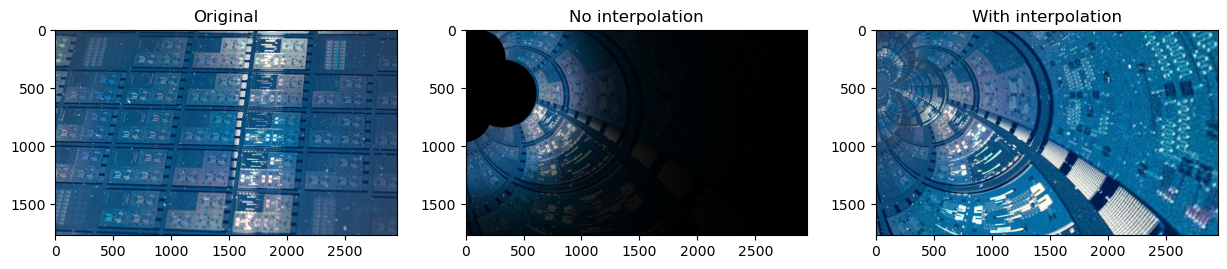

In [68]:
# M must be >1
# The smaller M is, the more "normal" the output looks
M=7

# Mode can be chosen from 'reflect’, ‘constant’, ‘nearest’, ‘mirror’, ‘wrap’
mode = 'wrap'

# If user_defined == False, then it is random (recommended)
user_defined = False
start_points = 32, 16, 16, 32, 32, 48 
end_points = 16, 32, 32, 48, 48, 32
new_image, uninterpolated_image = mobius_fast_interpolation(image,
                                                            M, 
                                                            mode = mode,
                                                            output_height=height, 
                                                            output_width=width,
                                                            user_defined=user_defined,
                                                            start_points = start_points,
                                                            end_points = end_points)

In [ ]:
new_image

In [ ]:
uninterpolated_image